In [14]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns





    


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=8,
            #is_unbalance=True,
            n_estimators=10000,
            
            bagging_fraction=0.8028, # 0.9,
            bagging_freq = 1,# 5,
            
            learning_rate= 0.0076, # 0.01,
            num_leaves=39, # 32,
            colsample_bytree= 0.8702, # 0.9497036,
            subsample= 0.9033, # 0.8715623,
            max_depth=10,
            reg_alpha=0.1853, # 0.04,
            reg_lambda=0.0305, # 0.073,
            min_split_gain=0.0299, #0.0222415,
            min_child_weight=45, # 40,
            silent=-1,
            verbose=-1,
            #scale_pos_weight=11
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')




In [3]:
Nan_matters_col = ['OCCUPATION_TYPE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

org_dic = {'Advertising': 2,
 'Agriculture': 3,
 'Bank': 0,
 'Business Entity Type 1': 2,
 'Business Entity Type 2': 2,
 'Business Entity Type 3': 2,
 'Cleaning': 3,
 'Construction': 3,
 'Culture': 0,
 'Electricity': 1,
 'Emergency': 1,
 'Government': 1,
 'Hotel': 1,
 'Housing': 1,
 'Industry: type 1': 3,
 'Industry: type 10': 1,
 'Industry: type 11': 2,
 'Industry: type 12': 0,
 'Industry: type 13': 3,
 'Industry: type 2': 1,
 'Industry: type 3': 3,
 'Industry: type 4': 3,
 'Industry: type 5': 1,
 'Industry: type 6': 1,
 'Industry: type 7': 2,
 'Industry: type 8': 3,
 'Industry: type 9': 1,
 'Insurance': 0,
 'Kindergarten': 1,
 'Legal Services': 1,
 'Medicine': 1,
 'Military': 0,
 'Mobile': 2,
 'Other': 1,
 'Police': 0,
 'Postal': 2,
 'Realtor': 3,
 'Religion': 0,
 'Restaurant': 3,
 'School': 0,
 'Security': 2,
 'Security Ministries': 0,
 'Self-employed': 3,
 'Services': 1,
 'Telecom': 1,
 'Trade: type 1': 2,
 'Trade: type 2': 1,
 'Trade: type 3': 3,
 'Trade: type 4': 0,
 'Trade: type 5': 1,
 'Trade: type 6': 0,
 'Trade: type 7': 2,
 'Transport: type 1': 0,
 'Transport: type 2': 1,
 'Transport: type 3': 3,
 'Transport: type 4': 2,
 'University': 0,
 'XNA': 0}

In [4]:


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../../data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../../data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    # 我添加的
    df['DAYS_EMPLOYED_365243'] = df['DAYS_EMPLOYED'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    #for col in Nan_matters_col:
    #    df[col+'_NAN'] = df[col].map(lambda x: 1 if  pd.isnull(x) else 0)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = (df['AMT_CREDIT'] / df['AMT_ANNUITY']).replace(np.inf, np.nan)
    df['NEW_CREDIT_TO_GOODS_RATIO'] = (df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']).replace(np.inf, np.nan)
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = (df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])).replace(np.inf, np.nan)
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = (df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = (df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])).replace(np.inf, np.nan)
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = (df['OWN_CAR_AGE'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['NEW_CAR_TO_EMPLOY_RATIO'] = (df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']).replace(np.inf, np.nan)
    df['NEW_PHONE_TO_BIRTH_RATIO'] = (df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = (df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']).replace(np.inf, np.nan)
    df['NEW_CREDIT_TO_INCOME_RATIO'] = (df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']).replace(np.inf, np.nan)
    
#     # 我的变量 start
    df['have_car_and_house'] =  list(map(lambda x, y: 1 if x=='Y' and y=='Y' else 0, df['FLAG_OWN_CAR'], df['FLAG_OWN_REALTY']))
    df['income_credict_ratio'] = (df['AMT_INCOME_TOTAL'] /df['AMT_CREDIT']).replace(np.inf, np.nan)
    edu_map = {'Academic degree':0, 'Higher education':1, 'Incomplete higher':2, 'Secondary / secondary special':3, 'Lower secondary':4}
    df['education_type'] = df['NAME_EDUCATION_TYPE'].map(edu_map)
    df['credit_age_ratio'] = (df['AMT_CREDIT'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['days_start_work'] = (df['DAYS_BIRTH'] - df['DAYS_EMPLOYED'])
    df['days_start_buy_car'] = (df['DAYS_BIRTH'] - df['OWN_CAR_AGE'])
    df['mobile'] = list(map(int, np.logical_or(df['FLAG_EMP_PHONE'] , np.logical_or(df['FLAG_WORK_PHONE'], df['FLAG_PHONE']))))
    df['adult_num'] = list(map(lambda x, y: 1 if x-y==1 and x != 1 else 0, df['CNT_FAM_MEMBERS'], df['CNT_CHILDREN']))
    df['region_rationg'] = df['REGION_RATING_CLIENT'] * df['REGION_RATING_CLIENT_W_CITY']
    credit_by_org = df[['AMT_CREDIT', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_CREDIT']
    df['credict_by_org'] =  df['ORGANIZATION_TYPE'].map(credit_by_org)
    df['org_is_nan'] = df['ORGANIZATION_TYPE'].map(lambda x: 1 if x == 'XNA' else 0)
    df['org_id'] = df['ORGANIZATION_TYPE'].map(org_dic)
    df['ext_source'] = np.nanmedian(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    df['ext_source2'] = np.nansum(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)
    df['ext_source3'] = np.nanmin(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)


    df['app missing'] = df.isnull().sum(axis = 1).values
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = (df['EXT_SOURCE_1'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = (df['EXT_SOURCE_2'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = (df['EXT_SOURCE_3'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)

    df['app AMT_CREDIT - AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_GOODS_PRICE'] = (df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']).replace(np.inf, np.nan)
    df['app AMT_CREDIT / AMT_ANNUITY'] = (df['AMT_CREDIT'] / df['AMT_ANNUITY']).replace(np.inf, np.nan)
    df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = (df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']).replace(np.inf, np.nan)

    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = (df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']).replace(np.inf, np.nan)
    df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
    df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = (df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']).replace(np.inf, np.nan)
    df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = (df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])).replace(np.inf, np.nan)

    df['app most popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
    df['app popular AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'] \
                        .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})

    df['app OWN_CAR_AGE / DAYS_BIRTH'] = (df['OWN_CAR_AGE'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = (df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']).replace(np.inf, np.nan)

    df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = (df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = (df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']).replace(np.inf, np.nan)
    df['app DAYS_EMPLOYED - DAYS_BIRTH'] = (df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']).replace(np.inf, np.nan)
    df['app DAYS_EMPLOYED / DAYS_BIRTH'] = (df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']).replace(np.inf, np.nan)

    df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = (df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']).replace(np.inf, np.nan)
    
    #  我的变量 end
    
    
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    dropcolum=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
    df= df.drop(dropcolum,axis=1)
    del test_df
    gc.collect()
    return df



In [5]:
def mode(x):
    temp = x.value_counts().index
    if len(temp) == 0:
        return np.nan
    else:
        return temp[0]

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../../data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../../data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    

    def weighted_mean(x, balance):
        weight = np.sqrt(-1 / balance[x.index])
        return np.nanmean(np.multiply(x, weight))
    
    bb['bb_not_zero'] = bb.loc[:, ['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis=1)
    # bb['bb_c_ratio'] =bb['STATUS_C'] / bb['BUREAU_BAL_COUNT']
    
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size'],
                      'bb_not_zero':['max', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
        
    bb = pd.merge(bb, bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='left')

    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    temp = [i for i in bb_agg.columns if 'STATUS_' in i]
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    bureau.loc[bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
    bureau.loc[bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
    bureau.loc[bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
    bureau.loc[bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
    bureau.loc[bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
    bureau.loc[(bureau['DAYS_CREDIT_UPDATE'] > 0) | (bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
    bureau.loc[bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan
    
    bureau['app_credit_annuity_ratio'] = (bureau['AMT_CREDIT_SUM'] /  bureau['AMT_ANNUITY']).replace(np.inf, np.nan)
    bureau['app_credit_debt_ratio'] = (bureau['AMT_CREDIT_SUM'] /  bureau['AMT_CREDIT_SUM_DEBT']).replace(np.inf, np.nan)
    bureau['app_credit_limit_ratio'] = (bureau['AMT_CREDIT_SUM'] /  bureau['AMT_CREDIT_SUM_LIMIT']).replace(np.inf, np.nan)
    bureau['app_credit_overdue_ratio'] = (bureau['AMT_CREDIT_SUM'] /  bureau['AMT_CREDIT_SUM_OVERDUE']).replace(np.inf, np.nan)
    bureau['weighted_credit'] = (bureau['AMT_CREDIT_SUM'] / np.sqrt(-bureau['DAYS_CREDIT'])).replace(np.inf, np.nan)
    

    bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_LIMIT']
    bureau['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_OVERDUE']
    
    
    bureau['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = bureau['DAYS_CREDIT'] - bureau['CREDIT_DAY_OVERDUE']
    bureau['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = bureau['DAYS_CREDIT_UPDATE'] - bureau['DAYS_CREDIT_ENDDATE']
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var', 'min'],
        'DAYS_CREDIT_ENDDATE': [ 'mean', 'max'],
        'DAYS_CREDIT_UPDATE': ['mean', 'min'],
        'DAYS_ENDDATE_FACT':['mean', 'max', 'min', 'var'],
        'CREDIT_DAY_OVERDUE': ['mean', 'max', 'var'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean','median'],
        'CNT_CREDIT_PROLONG': ['sum','mean','max'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'app_credit_annuity_ratio':['mean', 'median'],
        'app_credit_debt_ratio':['mean', 'median'],
        'app_credit_limit_ratio':['mean', 'median'],
        'app_credit_overdue_ratio':['mean', 'median'],
        'weighted_credit':['mean', 'sum', 'median'],
        'bb_not_zero_MEAN':['mean'],
        'bb_not_zero_MAX':['mean'],
        
    }
    
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for col in bureau.columns:
        if 'bureau' in col:
            cat_aggregations[col] = ['mean', 'max', 'min', 'std', 'median']
    for cat in bureau_cat: cat_aggregations[cat] = ['mean', 'sum']
    for cat in temp:
        cat_aggregations[cat] = ['mean', 'std', 'median']
    #for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean', 'sum', mode]
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../../data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    #prev['DAYS_LAST_DUE_ISNAN'] = prev['DAYS_LAST_DUE'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    #prev['DAYS_FIRST_DRAWING_ISNAN'] = prev['DAYS_FIRST_DRAWING'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    #prev['DAYS_FIRST_DUE_ISNAN'] = prev['DAYS_FIRST_DUE'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    #prev['DAYS_LAST_DUE_1ST_VERSION_ISNAN'] = prev['DAYS_LAST_DUE_1ST_VERSION'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    #prev['DAYS_TERMINATION_ISNAN'] = prev['DAYS_TERMINATION'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # my features start
    prev['prev missing'] = prev.isnull().sum(axis = 1).values
    prev['prev AMT_APPLICATION / AMT_CREDIT'] = (prev['AMT_APPLICATION'] / prev['AMT_CREDIT']).replace(np.inf, np.nan)
    prev['prev AMT_APPLICATION - AMT_CREDIT'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['prev AMT_GOODS_PRICE - AMT_CREDIT'] = prev['AMT_GOODS_PRICE'] - prev['AMT_CREDIT']
    prev['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = prev['DAYS_FIRST_DRAWING'] - prev['DAYS_FIRST_DUE']
    prev['prev DAYS_TERMINATION less -500'] = (prev['DAYS_TERMINATION'] < -500).astype(int)
    
    prev['prev AMT_CREDIT / AMT_ANNUITY'] = (prev['AMT_CREDIT'] / prev['AMT_ANNUITY']).replace(np.inf, np.nan)
    prev['prev AMT_APPLICATION / AMT_ANNUITY'] = (prev['AMT_APPLICATION'] / prev['AMT_ANNUITY']).replace(np.inf, np.nan)
    prev['prev AMT_APPLICATION - AMT_ANNUITY'] = prev['AMT_APPLICATION'] - prev['AMT_ANNUITY']
    prev['prev AMT_APPLICATION / AMT_DOWN_PAYMENT'] = (prev['AMT_APPLICATION'] / prev['AMT_DOWN_PAYMENT']).replace(np.inf, np.nan)
    prev['prev AMT_APPLICATION - AMT_DOWN_PAYMENT'] = prev['AMT_APPLICATION'] - prev['AMT_DOWN_PAYMENT']
    prev['prev RATE_INTEREST_PRIMARY - RATE_INTEREST_PRIVILEGED'] = prev['RATE_INTEREST_PRIMARY'] - prev['RATE_INTEREST_PRIVILEGED']
    prev['prev AMT_APPLICATION / CNT_PAYMENT'] = (prev['AMT_APPLICATION'] / prev['CNT_PAYMENT']).replace(np.inf, np.nan)
    
    
    # my features end
    
    
    # Add feature: value ask / value received percentage
    #prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean', 'min'],
        'AMT_APPLICATION': [ 'max','mean', 'min', 'size'],
        'AMT_CREDIT': [ 'max', 'mean', 'min', 'std'],
        #'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean', 'min'],
        'AMT_GOODS_PRICE': [ 'max', 'mean', 'min', 'sum'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean', 'min'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean', 'min'],
        'DAYS_DECISION': [ 'max', 'mean', 'min'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'RATE_INTEREST_PRIMARY': [ 'max', 'mean', 'min'],
        'RATE_INTEREST_PRIVILEGED': [ 'max', 'mean', 'min'],
    }
#         'DAYS_LAST_DUE_ISNAN':['mean', 'sum'], 
#         'DAYS_FIRST_DRAWING_ISNAN':['mean', 'sum'], 
#         'DAYS_FIRST_DUE_ISNAN':['mean', 'sum'], 
#         'DAYS_LAST_DUE_1ST_VERSION_ISNAN':['mean', 'sum'], 
#         'DAYS_TERMINATION_ISNAN':['mean', 'sum'], 
    for i in prev.columns:
        if 'prev' in i:
            num_aggregations[i] = ['mean'] #  'min', 'max', 'size', 'mean', 'var', 'sum']
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [8]:

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../../data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # my feature start
    pos['pos installment_sum'] = pos['CNT_INSTALMENT'] + pos['CNT_INSTALMENT_FUTURE']
    pos['pos dpd_sum'] = pos['SK_DPD'] + pos['SK_DPD_DEF']
    
    # my feature end
    
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min'],
        'SK_DPD': [ 'max', 'mean'],
        'SK_DPD_DEF': [ 'max', 'mean'],
        'pos installment_sum': ['sum', 'max', 'mean'],
        'CNT_INSTALMENT': ['sum', 'max', 'mean'],
        'CNT_INSTALMENT_FUTURE': ['sum', 'max', 'mean'],
        'pos dpd_sum': ['sum', 'max', 'mean'],
    }
    for cat in cat_cols:
        aggregations[cat] =[ 'max', 'mean', 'sum']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    pos_agg_prev = pos.groupby('SK_ID_PREV').agg(aggregations)
    pos_agg_prev.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg_prev.columns.tolist()])
    pos_agg_prev = pd.merge(pos_agg_prev, pos[['SK_ID_PREV', 'SK_ID_CURR']], left_index=True, right_on='SK_ID_PREV',how='left')
    pos_agg_prev = pos_agg_prev.drop(columns=['SK_ID_PREV'])
    aggregation2 = {}
    for i in pos_agg_prev.columns:
        aggregation2[i] = ['mean', 'max']
    pos_agg_prev2 = pos_agg_prev.groupby('SK_ID_CURR').agg(aggregation2)
    pos_agg_prev2.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg_prev2.columns.tolist()])
    pos_agg_prev2 = pos_agg_prev2.drop(columns=['POS_SK_ID_CURR_MEAN', 'POS_SK_ID_CURR_MAX'])
    
    pos_agg = pos_agg.join(pos_agg_prev2, how='left')
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos, pos_agg_prev, pos_agg_prev2
    gc.collect()
    return pos_agg

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../../data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = (ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']).replace(np.inf, np.nan)
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # my feature start
    ins['ins AMT_INSTALMENT==AMT_PAYMENT'] = (ins['AMT_INSTALMENT'] == ins['AMT_PAYMENT']).astype('int')
    ins['ins DPD_ratio'] = (ins['DAYS_ENTRY_PAYMENT'] / ins['DAYS_INSTALMENT']).replace(np.inf, np.nan)
    ins['ins NUM_INSTALMENT_VERSION=1'] = ins['NUM_INSTALMENT_VERSION'].map(lambda x: 1 if x == 1 else 0 if not pd.isnull(x) else np.nan)
    ins['ins NUM_INSTALMENT_VERSION=0'] = ins['NUM_INSTALMENT_VERSION'].map(lambda x: 1 if x == 0 else 0 if not pd.isnull(x) else np.nan)
    #ins['ins AMT_PAYMENT / DPD'] =(ins['AMT_PAYMENT'] / ins['DPD']).replace(np.inf, np.nan)
    
    # my feature end
    
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min' ],
        'DBD': ['max', 'mean', 'sum','min'],
        'PAYMENT_PERC': [ 'max','mean','min'],
        'PAYMENT_DIFF': [ 'max','mean','min'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
        'NUM_INSTALMENT_NUMBER': ['max'],
        'NUM_INSTALMENT_VERSION': ['max'],
    }
    for col in ins.columns:
        if 'ins' in col:
            aggregations[col] = ['mean', 'max', 'min']
    
    for cat in cat_cols:
        aggregations[cat] =[ 'max', 'mean', 'sum']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    
    ins_agg_prev = ins.groupby('SK_ID_PREV').agg(aggregations)
    ins_agg_prev.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg_prev.columns.tolist()])
    ins_agg_prev = pd.merge(ins_agg_prev, ins[['SK_ID_PREV', 'SK_ID_CURR']], left_index=True, right_on='SK_ID_PREV',how='left')
    ins_agg_prev = ins_agg_prev.drop(columns=['SK_ID_PREV'])
    aggregation2 = {}
    for i in ins_agg_prev.columns:
        aggregation2[i] = ['mean', 'max', 'min']
    ins_agg_prev2 = ins_agg_prev.groupby('SK_ID_CURR').agg(aggregation2)
    ins_agg_prev2.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg_prev2.columns.tolist()])
    ins_agg_prev2 = ins_agg_prev2.drop(columns=['INS_SK_ID_CURR_MEAN', 'INS_SK_ID_CURR_MAX','INS_SK_ID_CURR_MIN'])
    
    ins_agg = ins_agg.join(ins_agg_prev2, how='left')
    
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


In [10]:

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../../data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    
    # my feature start
    cc['cc AMT_BALANCE / MONTHS_BALANCE'] = (cc['AMT_BALANCE'] / cc['MONTHS_BALANCE']).replace(np.inf, np.nan)
    cc['cc AMT_CREDIT_LIMIT_ACTUAL / AMT_BALANCE'] = (cc['AMT_CREDIT_LIMIT_ACTUAL'] / cc['AMT_BALANCE']).replace(np.inf, np.nan)
    cc['cc AMOUNT_DRAWING_SUM'] = cc['AMT_DRAWINGS_ATM_CURRENT'] + cc['AMT_DRAWINGS_CURRENT'] + \
                            cc['AMT_DRAWINGS_OTHER_CURRENT'] + cc['AMT_DRAWINGS_POS_CURRENT']
    cc['cc AMT_BALANCE / AMT_INST_MIN_REGULARITY'] = (cc['AMT_BALANCE'] / cc['AMT_INST_MIN_REGULARITY']).replace(np.inf, np.nan)
    cc['cc AMT_BALANCE / AMT_PAYMENT_CURRENT'] = (cc['AMT_BALANCE'] / cc['AMT_PAYMENT_CURRENT']).replace(np.inf, np.nan)
    cc['cc AMT_PAYMENT_CURRENT / AMT_INST_MIN_REGULARITY'] = (cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']).replace(np.inf, np.nan)
    cc['cc AMT_PAYMENT_CURRENT / AMT_PAYMENT_TOTAL_CURRENT'] = (cc['AMT_PAYMENT_CURRENT'] / cc['AMT_PAYMENT_TOTAL_CURRENT']).replace(np.inf, np.nan)
    cc['cc AMT_RECIVABLE / AMT_RECEIVABLE_PRINCIPAL'] = (cc['AMT_RECIVABLE'] / cc['AMT_RECEIVABLE_PRINCIPAL']).replace(np.inf, np.nan)
    cc['cc AMT_RECIVABLE / AMT_TOTAL_RECEIVABLE'] = (cc['AMT_RECIVABLE'] / cc['AMT_TOTAL_RECEIVABLE']).replace(np.inf, np.nan)
    
    
    cc['cc AMT_DRAWINGS_ATM_CURRENT / CNT_DRAWINGS_ATM_CURRENT'] = (cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['CNT_DRAWINGS_ATM_CURRENT']).replace(np.inf, np.nan)
    cc['cc AMT_DRAWINGS_CURRENT / CNT_DRAWINGS_CURRENT'] = (cc['AMT_DRAWINGS_CURRENT'] / cc['CNT_DRAWINGS_CURRENT']).replace(np.inf, np.nan)
    cc['cc AMT_DRAWINGS_OTHER_CURRENT / CNT_DRAWINGS_OTHER_CURRENT'] = (cc['AMT_DRAWINGS_OTHER_CURRENT'] / cc['CNT_DRAWINGS_OTHER_CURRENT']).replace(np.inf, np.nan)
    cc['cc AMT_DRAWINGS_POS_CURRENT / CNT_DRAWINGS_POS_CURRENT'] = (cc['AMT_DRAWINGS_POS_CURRENT'] / cc['CNT_DRAWINGS_POS_CURRENT']).replace(np.inf, np.nan)
    
    cc['cc CNT_DRAWING_SUM'] = cc['CNT_DRAWINGS_ATM_CURRENT'] + cc['CNT_DRAWINGS_CURRENT'] + \
                            cc['CNT_DRAWINGS_OTHER_CURRENT'] + cc['CNT_DRAWINGS_POS_CURRENT']
    
    cc['cc AMT_DRAWING / CNT_DRAWING'] = (cc['cc AMOUNT_DRAWING_SUM']  / cc['cc CNT_DRAWING_SUM']).replace(np.inf, np.nan)
    # my feature end
   
    cc_agg_prev = cc.groupby('SK_ID_PREV').agg([ 'max', 'mean'])
    cc_agg_prev.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg_prev.columns.tolist()])
    cc_agg_prev = pd.merge(cc_agg_prev, cc[['SK_ID_PREV', 'SK_ID_CURR']], left_index=True, right_on='SK_ID_PREV',how='left')
    cc_agg_prev = cc_agg_prev.drop(columns=['SK_ID_PREV'])
    cc_agg_prev2 = cc_agg_prev.groupby('SK_ID_CURR').agg(['mean'])
    cc_agg_prev2.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg_prev2.columns.tolist()])
    #cc_agg_prev2 = cc_agg_prev2.drop(columns=['CC_SK_ID_CURR_MEAN', 'CC_SK_ID_CURR_MAX','CC_SK_ID_CURR_MIN'])
    
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'min', 'sum'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    cc_agg = cc_agg.join(cc_agg_prev2, how='left')
    
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
a = credit_card_balance(1000)

print(len(a.columns))
    

231


# test

# Table 6

In [155]:
cc = pd.read_csv('../../data/credit_card_balance.csv', nrows = 100000)
cc.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


# Table 5

In [131]:
ins = pd.read_csv('../../data/installments_payments.csv', nrows = 100000)
ins.sample(10)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
73469,2718060,102923,1.0,2,-1789.0,-1802.0,3154.545,3154.545
89072,1586285,175156,1.0,2,-370.0,-395.0,17902.575,17902.575
50321,2640957,103329,0.0,10,-2740.0,-2749.0,9000.000,9000.000
48223,1923386,192849,0.0,56,-1534.0,-1516.0,3375.000,2925.000
21282,2755083,134789,0.0,77,-171.0,-171.0,1623.825,1623.825
25730,2609535,175984,1.0,9,-277.0,-309.0,7025.580,7025.580
79528,2178596,190893,0.0,34,-2188.0,-2186.0,10800.000,10800.000
92646,2398067,119792,0.0,23,-176.0,-176.0,206640.000,206640.000
80449,2361856,192085,1.0,5,-673.0,-738.0,9878.040,9878.040
34990,1518522,148679,2.0,3,-188.0,-200.0,132511.185,132511.185


In [ ]:
ins['equal'] =(ins['AMT_INSTALMENT'] == ins['AMT_PAYMENT']).astype('int')
ins.equal.value_counts()

In [138]:
a = pd.DataFrame([[1,0], [2,1]])
a[2] = (a[0]/a[1]).replace(np.inf, np.nan)
a

,0,1,2
0,1,0,NaN
1,2,1,2.0


# Table 3

In [68]:
nrows = None

In [101]:
pos = pd.read_csv('../../data/POS_CASH_balance.csv', nrows = 100000)
pos['pos installment_sum'] = pos['CNT_INSTALMENT'] + pos['CNT_INSTALMENT_FUTURE']
pos['pos dpd_sum'] = pos['SK_DPD'] + pos['SK_DPD_DEF']
aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min'],
        'SK_DPD': [ 'max', 'mean'],
        'SK_DPD_DEF': [ 'max', 'mean'],
        'pos installment_sum': ['sum', 'max', 'mean'],
        'CNT_INSTALMENT': ['sum', 'max', 'mean'],
        'CNT_INSTALMENT_FUTURE': ['sum', 'max', 'mean'],
        'pos dpd_sum': ['sum', 'max', 'mean'],
    }

pos_agg_prev = pos.groupby('SK_ID_PREV').agg(aggregations)
pos_agg_prev.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg_prev.columns.tolist()])

In [114]:
pos_agg_prev = pd.merge(pos_agg_prev, pos[['SK_ID_PREV', 'SK_ID_CURR']], left_index=True, right_on='SK_ID_PREV',how='left')
pos_agg_prev = pos_agg_prev.drop(columns=['SK_ID_PREV'])
aggregation2 = {}
for i in pos_agg_prev.columns:
    aggregation2[i] = ['mean', 'max']
#pos_agg_prev.groupby('SK_ID_CURR').agg(aggregation2)


In [79]:
pos = pd.read_csv('../../data/previous_application.csv', nrows = nrows)
len(np.unique(pos['SK_ID_CURR']))

338857

In [71]:
pos = pd.read_csv('../../data/credit_card_balance.csv', nrows = nrows)
len(np.unique(pos['SK_ID_CURR']))

103558

# Table 2

In [57]:
bureau = pd.read_csv('../../data/bureau.csv', nrows = None)
bb = pd.read_csv('../../data/bureau_balance.csv', nrows = None)
bb, bb_cat = one_hot_encoder(bb, True)
bureau, bureau_cat = one_hot_encoder(bureau, True)

In [59]:
def weighted_mean(x, balance):
    weight = np.sqrt(-1 / balance[x.index])
    return np.nanmean(np.multiply(x, weight))
    
bb['bb_not_zero'] = bb.loc[:, ['STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5']].sum(axis=1)

wm = lambda x: weighted_mean(x, bb['MONTHS_BALANCE'])

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size'],
                  'bb_not_zero': ['mean', wm]}
for col in bb_cat:
    bb_aggregations[col] = ['mean', wm]

bb = pd.merge(bb, bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='left')

In [61]:
bb_agg_2 = bb.groupby('SK_ID_CURR').agg(bb_aggregations)

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

In [ ]:
# 有将近一半的样本没有匹配到 balance数据，作为新特征

In [96]:
num_aggregations = {
    'DAYS_CREDIT': [ 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': [ 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': [ 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    'bb_not_zero_MEAN': ['mean', 'sum', 'std'],
    'bb_not_zero_<LAMBDA>': ['mean', 'sum', 'std']
}
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: 
    cat_aggregations[cat + "_MEAN"] = ['mean']
    cat_aggregations[cat + "_<LAMBDA>"] = ['mean']
    
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

In [99]:
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')


In [102]:
bb_agg_2.columns = pd.Index(['BB2_' + e[0] + "_" + e[1].upper() for e in bb_agg_2.columns.tolist()])


In [105]:
bureau_agg = bureau_agg.join(bb_agg_2, how='left', on='SK_ID_CURR')

In [111]:
bureau_agg['HAS_NO_BALANCE_DATA'] = bureau_agg['BB2_MONTHS_BALANCE_MAX'].map(lambda x: 1 if pd.isnull(x) else 0)

In [113]:
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')

In [114]:
df.shape

(356251, 431)

# test table 1

In [40]:
df_temp = pd.read_csv('../../data/application_train.csv')

In [144]:
df_temp['FLAG_OWN_CAR']

0         N
1         N
2         Y
3         N
4         N
5         N
6         Y
7         Y
8         N
9         N
10        N
11        N
12        N
13        Y
14        N
15        Y
16        N
17        N
18        N
19        N
20        Y
21        Y
22        N
23        N
24        Y
25        N
26        N
27        N
28        Y
29        N
         ..
307481    N
307482    Y
307483    N
307484    Y
307485    N
307486    Y
307487    N
307488    N
307489    N
307490    N
307491    Y
307492    Y
307493    N
307494    Y
307495    Y
307496    N
307497    Y
307498    Y
307499    N
307500    N
307501    N
307502    N
307503    N
307504    N
307505    N
307506    N
307507    N
307508    N
307509    N
307510    N
Name: FLAG_OWN_CAR, Length: 307511, dtype: object

In [111]:
df['temp1'] = np.nanmin(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN axis encountered
  """Entry point for launching an IPython kernel.


/usr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


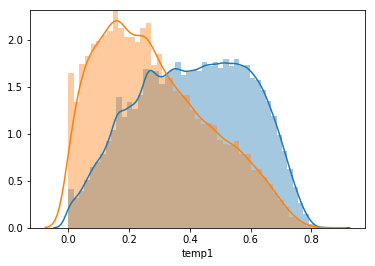

In [112]:
import seaborn as sns
sns.distplot(df.loc[df['TARGET']==0, 'temp1'].dropna())
sns.distplot(df.loc[df['TARGET']==1, 'temp1'].dropna())

In [138]:
df_temp.groupby(['AMT_REQ_CREDIT_BUREAU_YEAR'])['TARGET'].agg(['mean', 'count'])

,mean,count
AMT_REQ_CREDIT_BUREAU_YEAR,,
0.0,0.071350,71801
1.0,0.073338,63405
2.0,0.081049,50192
3.0,0.079577,33628
4.0,0.082553,20714
5.0,0.083223,12052
6.0,0.090713,6967
7.0,0.092013,3869
8.0,0.086037,2127


In [34]:
[i for i in df.columns if 'NAME_INCOME_TYPE' in i]

['NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working']

In [82]:
feat_importance.groupby('feature')['importance'].mean()['NEW_INC_BY_ORG']

114.6

# test end

In [12]:
debug = False
num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()


Train samples: 307511, test samples: 48744


/usr/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: All-NaN axis encountered


Bureau df shape: (305811, 254)
Process bureau and bureau_balance - done in 46s
Previous applications df shape: (338857, 306)
Process previous_applications - done in 33s
Pos-cash balance df shape: (337252, 151)
Process POS-CASH balance - done in 83s
Installments payments df shape: (339587, 157)
Process installments payments - done in 101s
Credit card balance df shape: (103558, 261)
Process credit card balance - done in 45s


Starting LightGBM. Train shape: (307507, 1415), test shape: (48744, 1415)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.833492	valid_1's auc: 0.793486
[2000]	training's auc: 0.867891	valid_1's auc: 0.798864
[3000]	training's auc: 0.893009	valid_1's auc: 0.800139
Early stopping, best iteration is:
[3195]	training's auc: 0.897251	valid_1's auc: 0.800307
Fold  1 AUC : 0.800307
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.833249	valid_1's auc: 0.791476
[2000]	training's auc: 0.867395	valid_1's auc: 0.797022
[3000]	training's auc: 0.892247	valid_1's auc: 0.798361
Early stopping, best iteration is:
[3342]	training's auc: 0.899578	valid_1's auc: 0.798663
Fold  2 AUC : 0.798663
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.833262	valid_1's auc: 0.791537
[2000]	training's auc: 0.867962	valid_1's auc: 0.796499
[3000]	training's auc: 0.893032	valid_1's auc: 0.797499
Early

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 4537s


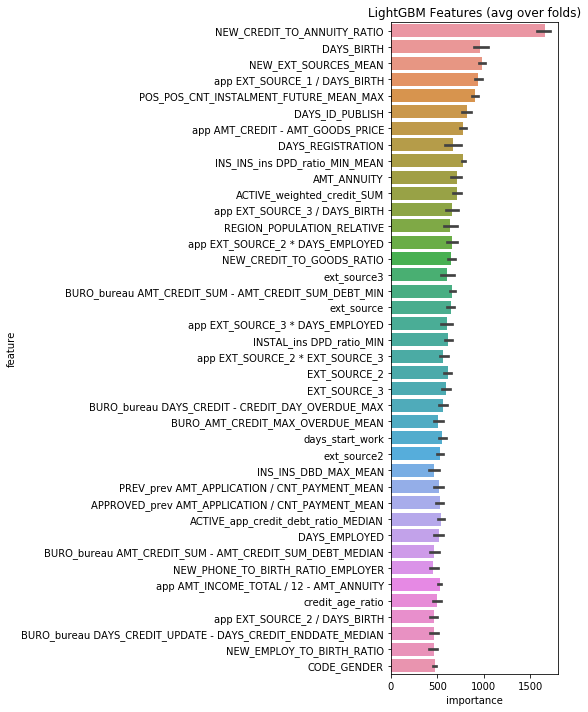

In [15]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01，同时加入36543异常值虚拟变量
# 使用bayes调参后的新参数
# Step |   Time |      Value |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
# 2 | 76m28s |    0.79698 |          0.0076 |      9.5087 |            44.9912 |           0.0299 |      38.6579 | 
# Step |   Time |      Value |   bagging_fraction |   bagging_freq |   colsample_bytree |   reg_alpha |   reg_lambda |   subsample | 
#     9 | 78m53s |    0.79776 |             0.8028 |         1.0074 |             0.8702 |      0.1853 |       0.0305 |      0.9033 | 
# 
# LB= 
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1415), test shape: (48744, 1415)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.833513	valid_1's auc: 0.793776
[2000]	training's auc: 0.867839	valid_1's auc: 0.7991
[3000]	training's auc: 0.892503	valid_1's auc: 0.800362
Early stopping, best iteration is:
[3133]	training's auc: 0.895457	valid_1's auc: 0.80046
Fold  1 AUC : 0.800460


/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1064s


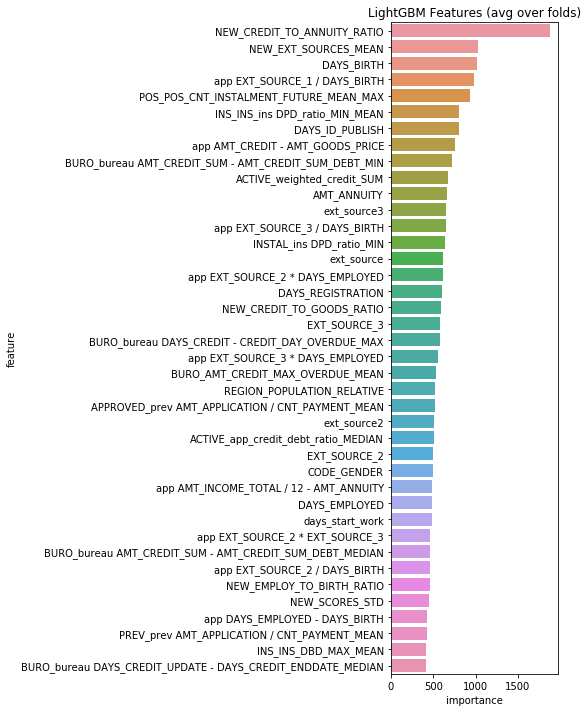

In [17]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01，同时加入36543异常值虚拟变量
# 只用第一个folder
# LB= 0.798
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [ ]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01，同时加入36543异常值虚拟变量
# 沿用原始参数，但是learning_rate 调整到0.005
# 效果不好
# LB= 
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1415), test shape: (48744, 1415)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.810799	valid_1's auc: 0.78655
[2000]	training's auc: 0.83644	valid_1's auc: 0.795101
[3000]	training's auc: 0.854619	valid_1's auc: 0.797956
[4000]	training's auc: 0.869375	valid_1's auc: 0.799237
[5000]	training's auc: 0.882525	valid_1's auc: 0.799801
Early stopping, best iteration is:
[4886]	training's auc: 0.881105	valid_1's auc: 0.799807
Fold  1 AUC : 0.799807
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.810575	valid_1's auc: 0.783562
[2000]	training's auc: 0.836205	valid_1's auc: 0.792674
[3000]	training's auc: 0.854264	valid_1's auc: 0.795496
[4000]	training's auc: 0.86874	valid_1's auc: 0.796794
[5000]	training's auc: 0.881679	valid_1's auc: 0.797491
Early stopping, best iteration is:
[5217]	training's auc: 0.884111	valid_1's auc: 0.797587
Fold  2 AUC : 0.797587
Training until 

Starting LightGBM. Train shape: (307507, 1415), test shape: (48744, 1415)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.833513	valid_1's auc: 0.793776
[2000]	training's auc: 0.867839	valid_1's auc: 0.7991
[3000]	training's auc: 0.892503	valid_1's auc: 0.800362
Early stopping, best iteration is:
[3133]	training's auc: 0.895457	valid_1's auc: 0.80046
Fold  1 AUC : 0.800460
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.833514	valid_1's auc: 0.791428
[2000]	training's auc: 0.867362	valid_1's auc: 0.796778
[3000]	training's auc: 0.892252	valid_1's auc: 0.798114
Early stopping, best iteration is:
[3110]	training's auc: 0.894537	valid_1's auc: 0.798311
Fold  2 AUC : 0.798311
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.83347	valid_1's auc: 0.791453
[2000]	training's auc: 0.867263	valid_1's auc: 0.796259
Early stopping, best iteration is:
[2750]	training's auc: 0.88634

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 4586s


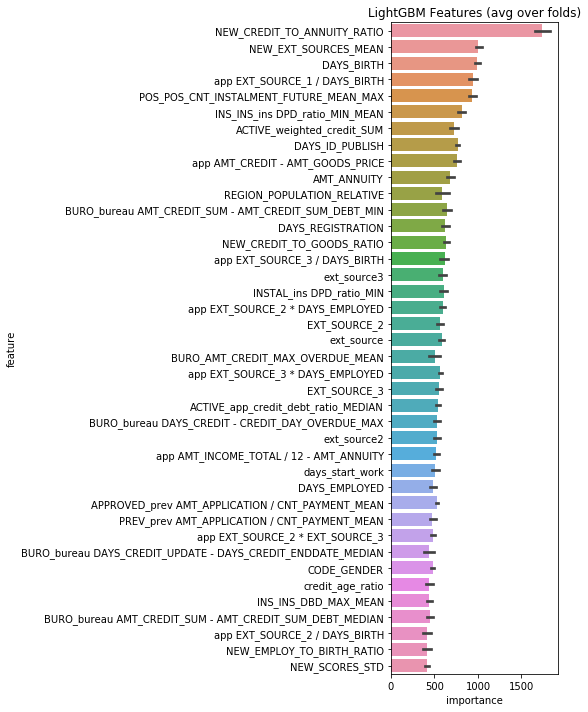

In [12]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01，同时加入36543异常值虚拟变量
# 使用bayes调参后的新参数
# Step |   Time |      Value |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves | 
# 2 | 76m28s |    0.79698 |          0.0076 |      9.5087 |            44.9912 |           0.0299 |      38.6579 | 
# LB= 0.802(融合之后)
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1705), test shape: (48744, 1705)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.836185	valid_1's auc: 0.794594
[2000]	training's auc: 0.870229	valid_1's auc: 0.798632
[3000]	training's auc: 0.895086	valid_1's auc: 0.799723
Early stopping, best iteration is:
[3050]	training's auc: 0.896263	valid_1's auc: 0.799757
Fold  1 AUC : 0.799757
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.836446	valid_1's auc: 0.792268
[2000]	training's auc: 0.869472	valid_1's auc: 0.79645
[3000]	training's auc: 0.894519	valid_1's auc: 0.797602
Early stopping, best iteration is:
[3160]	training's auc: 0.897737	valid_1's auc: 0.797834
Fold  2 AUC : 0.797834
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.836677	valid_1's auc: 0.792156
[2000]	training's auc: 0.870031	valid_1's auc: 0.795903
Early stopping, best iteration is:
[2124]	training's auc: 0.87

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 4169s


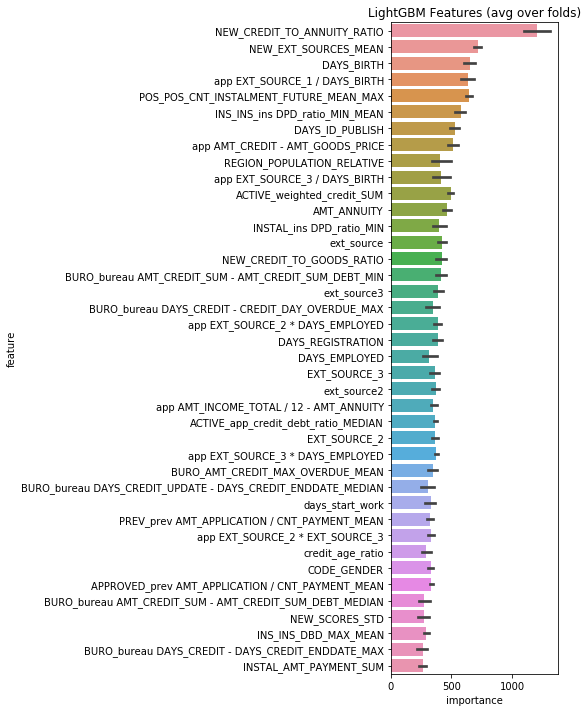

In [109]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01，同时加入36543异常值虚拟变量，加入多个表的STD聚合
# LB=0.800
# 效果不好
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1415), test shape: (48744, 1415)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.835805	valid_1's auc: 0.794845
[2000]	training's auc: 0.869075	valid_1's auc: 0.799115
[3000]	training's auc: 0.893623	valid_1's auc: 0.800135
Early stopping, best iteration is:
[3025]	training's auc: 0.894195	valid_1's auc: 0.800217
Fold  1 AUC : 0.800217
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.835926	valid_1's auc: 0.79243
[2000]	training's auc: 0.868519	valid_1's auc: 0.796464
Early stopping, best iteration is:
[2443]	training's auc: 0.880068	valid_1's auc: 0.797262
Fold  2 AUC : 0.797262
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.836315	valid_1's auc: 0.792678
[2000]	training's auc: 0.868881	valid_1's auc: 0.796374
Early stopping, best iteration is:
[2445]	training's auc: 0.880526	valid_1's auc: 0.796754
Fold  3 AUC : 0.796754
Trai

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 3490s


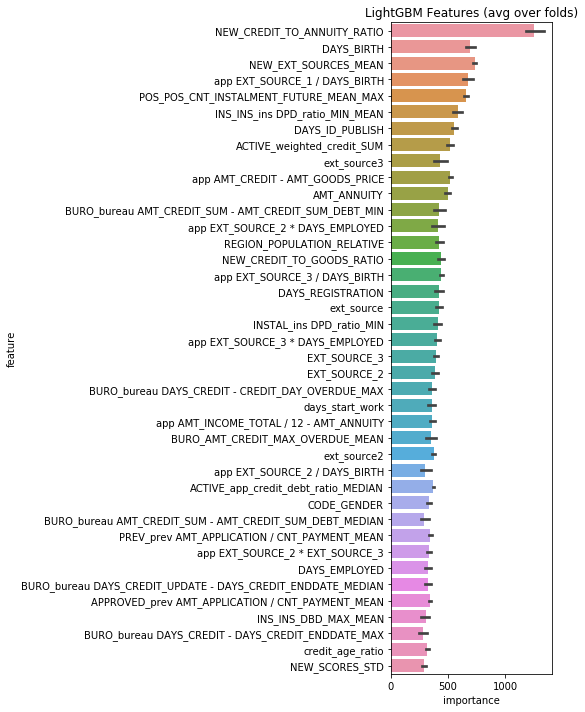

In [18]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01，同时加入36543异常值虚拟变量
# LB=0.800
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [98]:
temp = feat_importance.groupby('feature')['importance'].mean()
temp[[i for i in temp.index if 'STD' in i]]

feature
APPROVED_AMT_CREDIT_STD                                     178.4
BURO_STATUS_0_MEAN_STD                                      122.0
BURO_STATUS_1_MEAN_STD                                       42.8
BURO_STATUS_2_MEAN_STD                                        4.6
BURO_STATUS_3_MEAN_STD                                        1.0
BURO_STATUS_4_MEAN_STD                                        0.2
BURO_STATUS_5_MEAN_STD                                        0.4
BURO_STATUS_C_MEAN_STD                                       60.0
BURO_STATUS_X_MEAN_STD                                      105.8
BURO_STATUS_nan_MEAN_STD                                      0.0
BURO_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_STD        160.2
BURO_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT_STD       182.4
BURO_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE_STD     165.8
BURO_bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE_STD             80.0
BURO_bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE_STD           163.0
BU

Starting LightGBM. Train shape: (307507, 1414), test shape: (48744, 1414)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.835804	valid_1's auc: 0.79505
[2000]	training's auc: 0.869149	valid_1's auc: 0.799248
[3000]	training's auc: 0.893649	valid_1's auc: 0.800088
Early stopping, best iteration is:
[3040]	training's auc: 0.894533	valid_1's auc: 0.800175
Fold  1 AUC : 0.800175
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.836034	valid_1's auc: 0.792355
[2000]	training's auc: 0.868535	valid_1's auc: 0.796493
Early stopping, best iteration is:
[2412]	training's auc: 0.879279	valid_1's auc: 0.797268
Fold  2 AUC : 0.797268
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.836069	valid_1's auc: 0.79251
[2000]	training's auc: 0.868809	valid_1's auc: 0.796395
Early stopping, best iteration is:
[2430]	training's auc: 0.880353	valid_1's auc: 0.796829
Fold  3 AUC : 0.796829
Train

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 3355s


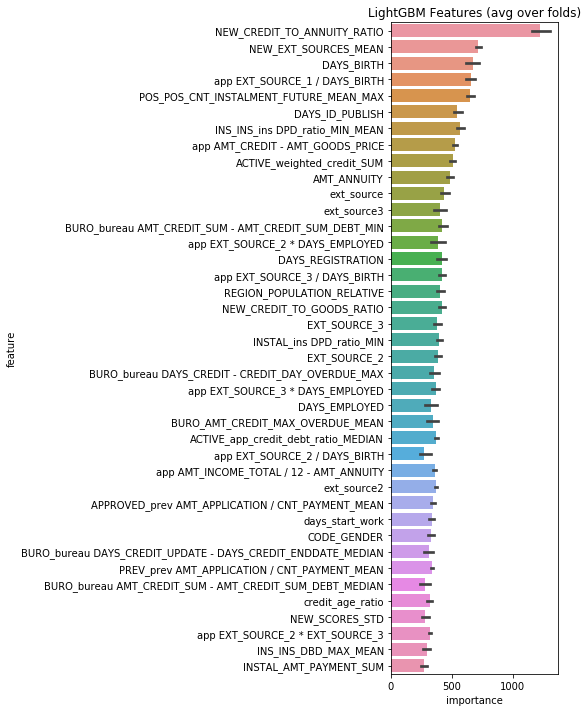

In [15]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，
# 全加上repalace(np.inf, np.nan)，加入bagging参数，同时调整learning_rate 参数为 0.01
# LB=0.800
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1414), test shape: (48744, 1414)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.868119	valid_1's auc: 0.798185
Early stopping, best iteration is:
[1696]	training's auc: 0.899527	valid_1's auc: 0.798896
Fold  1 AUC : 0.798896
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867536	valid_1's auc: 0.795943
Early stopping, best iteration is:
[1787]	training's auc: 0.901771	valid_1's auc: 0.797197
Fold  2 AUC : 0.797197
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.868759	valid_1's auc: 0.795096
Early stopping, best iteration is:
[1364]	training's auc: 0.886528	valid_1's auc: 0.795573
Fold  3 AUC : 0.795573
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.868115	valid_1's auc: 0.795207
Early stopping, best iteration is:
[1584]	training's auc: 0.89549	valid_1's auc: 0.795667
Fold  4 AUC : 0.79

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 2184s


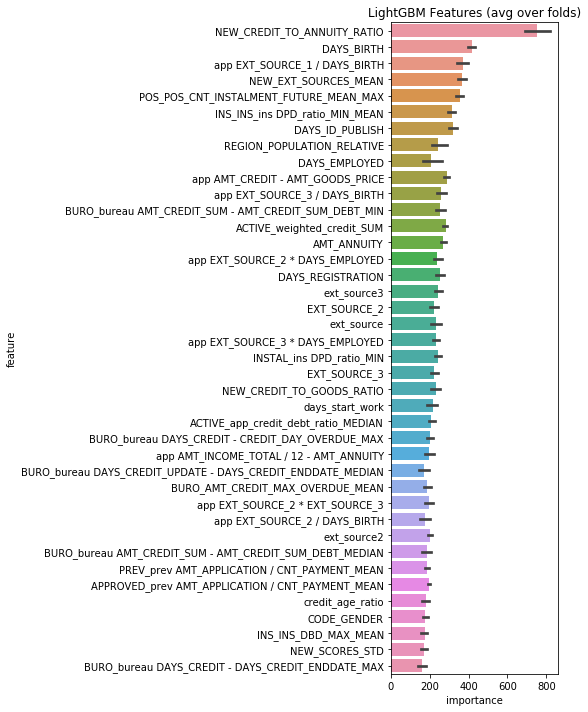

In [13]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，全加上repalace(np.inf, np.nan)
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [21]:
select_feat = [i for i in df.columns if i not in no_need]
df_temp = df.loc[:, select_feat]

In [ ]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征，剔除无效特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df_temp, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 985), test shape: (48744, 985)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867275	valid_1's auc: 0.797307
Early stopping, best iteration is:
[1596]	training's auc: 0.89465	valid_1's auc: 0.797967
Fold  1 AUC : 0.797967
Training until validation scores don't improve for 200 rounds.


Starting LightGBM. Train shape: (307507, 1414), test shape: (48744, 1414)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867836	valid_1's auc: 0.797738
Early stopping, best iteration is:
[1414]	training's auc: 0.887608	valid_1's auc: 0.798639
Fold  1 AUC : 0.798639
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867287	valid_1's auc: 0.795749
Early stopping, best iteration is:
[1720]	training's auc: 0.899212	valid_1's auc: 0.797095
Fold  2 AUC : 0.797095
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86781	valid_1's auc: 0.794657
Early stopping, best iteration is:
[1073]	training's auc: 0.871721	valid_1's auc: 0.794905
Fold  3 AUC : 0.794905
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.868389	valid_1's auc: 0.79528
Early stopping, best iteration is:
[1457]	training's auc: 0.890273	valid_1's auc: 0.795778
Fold  4 AUC : 0.795

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 2057s


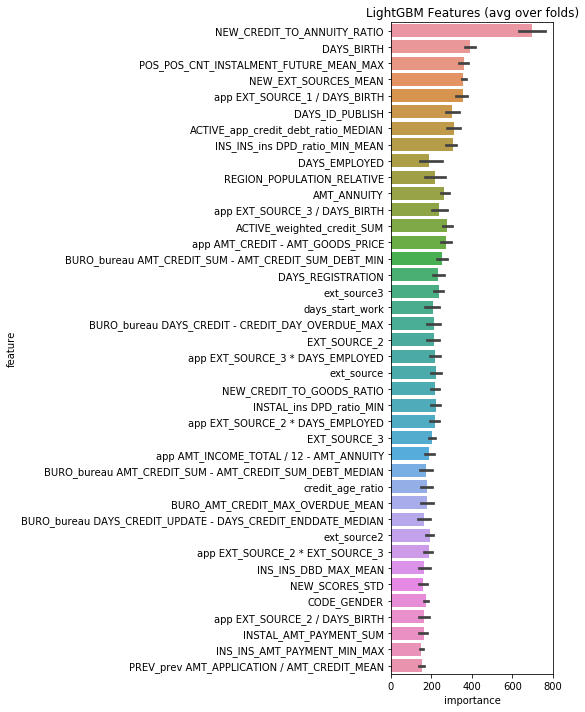

In [12]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征
# LB=0.799
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [13]:
temp = feat_importance.groupby('feature')['importance'].mean()

In [19]:
no_need = temp[temp<1].index

In [ ]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表自己的特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1854), test shape: (48744, 1854)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.868078	valid_1's auc: 0.797757
Early stopping, best iteration is:
[1361]	training's auc: 0.885904	valid_1's auc: 0.798435
Fold  1 AUC : 0.798438
Training until validation scores don't improve for 200 rounds.


Starting LightGBM. Train shape: (307507, 1266), test shape: (48744, 1266)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86768	valid_1's auc: 0.797674
Early stopping, best iteration is:
[1484]	training's auc: 0.890629	valid_1's auc: 0.798618
Fold  1 AUC : 0.798618
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867249	valid_1's auc: 0.795689
Early stopping, best iteration is:
[1396]	training's auc: 0.886631	valid_1's auc: 0.796619
Fold  2 AUC : 0.796619
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.868108	valid_1's auc: 0.794278
Early stopping, best iteration is:
[1646]	training's auc: 0.898196	valid_1's auc: 0.794921
Fold  3 AUC : 0.794921
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86797	valid_1's auc: 0.79467
Early stopping, best iteration is:
[1505]	training's auc: 0.892296	valid_1's auc: 0.794916
Fold  4 AUC : 0.7949

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1867s


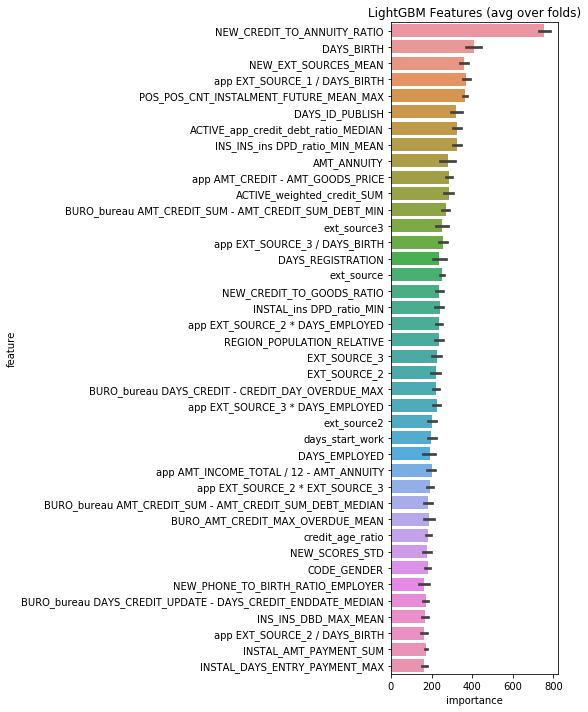

In [153]:
# 前六，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征，第六张表原始特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1153), test shape: (48744, 1153)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867236	valid_1's auc: 0.796805
Early stopping, best iteration is:
[1444]	training's auc: 0.888938	valid_1's auc: 0.79789
Fold  1 AUC : 0.797890
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866622	valid_1's auc: 0.795553
Early stopping, best iteration is:
[1389]	training's auc: 0.886152	valid_1's auc: 0.796302
Fold  2 AUC : 0.796299
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.867174	valid_1's auc: 0.793732
Early stopping, best iteration is:
[1609]	training's auc: 0.895688	valid_1's auc: 0.794285
Fold  3 AUC : 0.794285
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.866899	valid_1's auc: 0.794196
Early stopping, best iteration is:
[1518]	training's auc: 0.892026	valid_1's auc: 0.794745
Fold  4 AUC : 0.79

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1603s


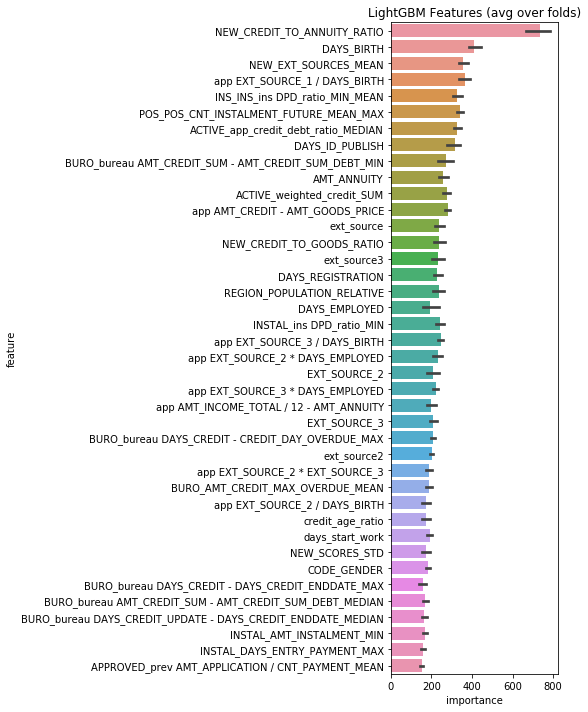

In [151]:
# 前五，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表自己的特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1032), test shape: (48744, 1032)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.865137	valid_1's auc: 0.794761
Early stopping, best iteration is:
[1368]	training's auc: 0.883427	valid_1's auc: 0.795522
Fold  1 AUC : 0.795522
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.864914	valid_1's auc: 0.792817
Early stopping, best iteration is:
[1575]	training's auc: 0.891639	valid_1's auc: 0.793766
Fold  2 AUC : 0.793760
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.865466	valid_1's auc: 0.791681
Early stopping, best iteration is:
[1521]	training's auc: 0.890018	valid_1's auc: 0.792101
Fold  3 AUC : 0.792101
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86581	valid_1's auc: 0.793101
Early stopping, best iteration is:
[1403]	training's auc: 0.885769	valid_1's auc: 0.7934
Fold  4 AUC : 0.7934

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1439s


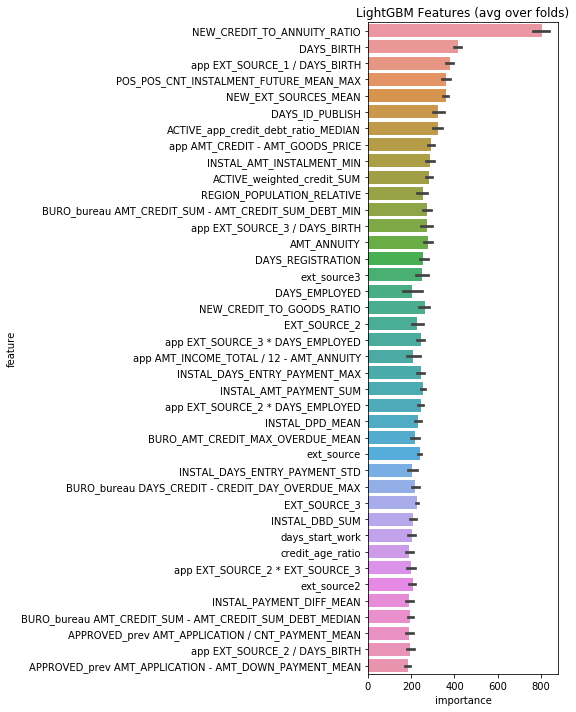

In [119]:
# 前五，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征，第五张表原始特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 996), test shape: (48744, 996)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861927	valid_1's auc: 0.792081
Early stopping, best iteration is:
[1411]	training's auc: 0.881473	valid_1's auc: 0.792413
Fold  1 AUC : 0.792413
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861913	valid_1's auc: 0.789807
Early stopping, best iteration is:
[1288]	training's auc: 0.876257	valid_1's auc: 0.790075
Fold  2 AUC : 0.790069
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861964	valid_1's auc: 0.789461
Early stopping, best iteration is:
[1291]	training's auc: 0.876317	valid_1's auc: 0.789785
Fold  3 AUC : 0.789785
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.862093	valid_1's auc: 0.789772
Early stopping, best iteration is:
[1778]	training's auc: 0.897864	valid_1's auc: 0.79052
Fold  4 AUC : 0.7905

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1308s


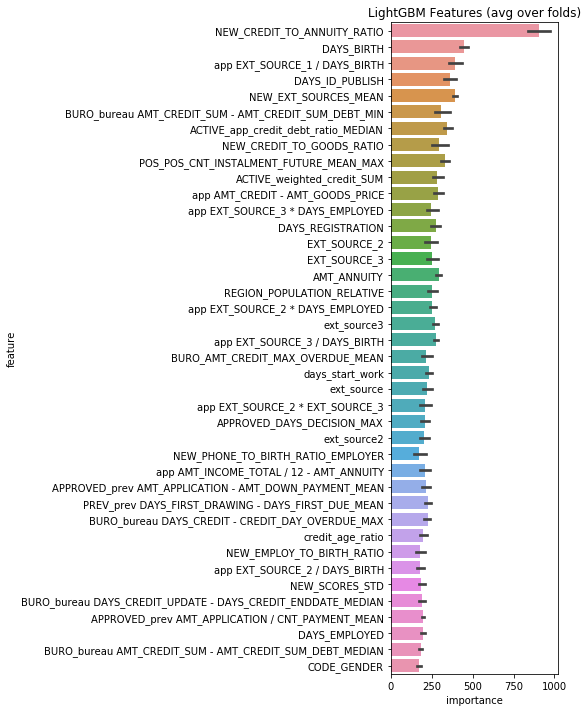

In [117]:
# 前四，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表自己的特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 897), test shape: (48744, 897)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861539	valid_1's auc: 0.791099
Early stopping, best iteration is:
[1035]	training's auc: 0.863405	valid_1's auc: 0.791172
Fold  1 AUC : 0.791174
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861078	valid_1's auc: 0.788934
Early stopping, best iteration is:
[1310]	training's auc: 0.876408	valid_1's auc: 0.789353
Fold  2 AUC : 0.789353
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861248	valid_1's auc: 0.789078
Early stopping, best iteration is:
[1188]	training's auc: 0.870881	valid_1's auc: 0.789402
Fold  3 AUC : 0.789402
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861174	valid_1's auc: 0.788998
Early stopping, best iteration is:
[1538]	training's auc: 0.887657	valid_1's auc: 0.789627
Fold  4 AUC : 0.789

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1128s


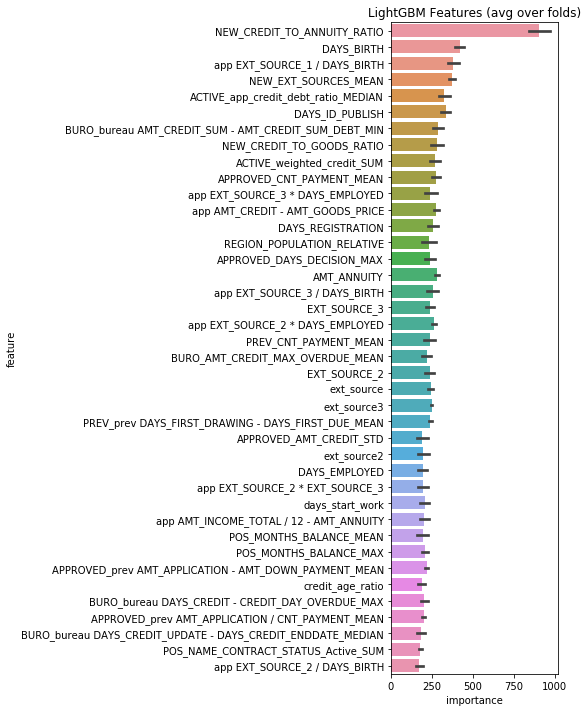

In [50]:
# 前4，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征，第四章表原始特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 845), test shape: (48744, 845)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859521	valid_1's auc: 0.789278
Early stopping, best iteration is:
[1069]	training's auc: 0.863073	valid_1's auc: 0.789473
Fold  1 AUC : 0.789473
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859456	valid_1's auc: 0.787273
Early stopping, best iteration is:
[1340]	training's auc: 0.876324	valid_1's auc: 0.78798
Fold  2 AUC : 0.787980
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859047	valid_1's auc: 0.787356
Early stopping, best iteration is:
[1361]	training's auc: 0.877005	valid_1's auc: 0.787725
Fold  3 AUC : 0.787725
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859837	valid_1's auc: 0.786689
Early stopping, best iteration is:
[1755]	training's auc: 0.8956	valid_1's auc: 0.787744
Fold  4 AUC : 0.787744

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1137s


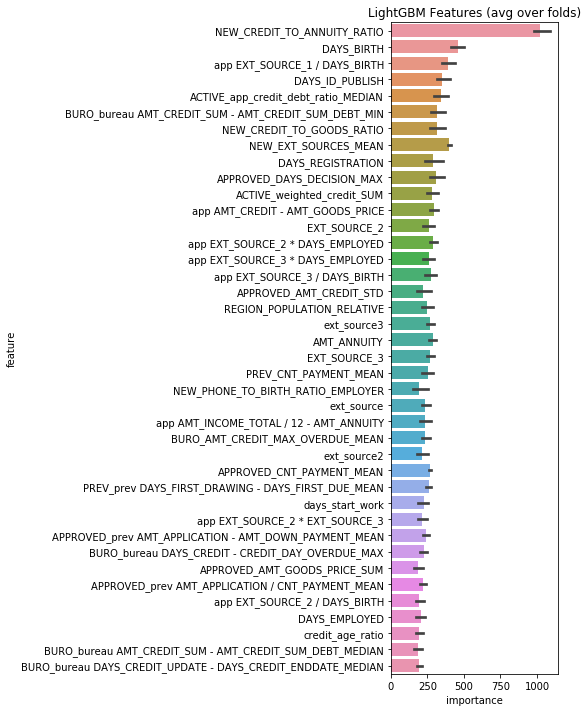

In [48]:
# 前三，第一张表自己的特征，第二章表自己的特征，第三章表自己的特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [46]:
temp.loc[temp == 0].index

Index(['PREV_prev DAYS_TERMINATION less -500_MAX', 'PREV_prev DAYS_TERMINATION less -500_MIN'], dtype='object', name='feature')

In [45]:
temp = feat_importance.groupby('feature')['importance'].mean()
temp = temp.loc[(temp.index.map(lambda x: 'prev' in x))]
temp.loc[temp == 0].index
marked = [i for i in df.columns if i not in temp.loc[temp == 0].index]

In [38]:
df = df[marked]

Starting LightGBM. Train shape: (307507, 758), test shape: (48744, 758)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.857551	valid_1's auc: 0.788587
Early stopping, best iteration is:
[1323]	training's auc: 0.873514	valid_1's auc: 0.789164
Fold  1 AUC : 0.789164
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.85757	valid_1's auc: 0.785609
Early stopping, best iteration is:
[1504]	training's auc: 0.881234	valid_1's auc: 0.786662
Fold  2 AUC : 0.786662
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.857311	valid_1's auc: 0.786385
Early stopping, best iteration is:
[1552]	training's auc: 0.88331	valid_1's auc: 0.786988
Fold  3 AUC : 0.786988
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.857236	valid_1's auc: 0.785773
Early stopping, best iteration is:
[1130]	training's auc: 0.864124	valid_1's auc: 0.785898
Fold  4 AUC : 0.78589

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 992s


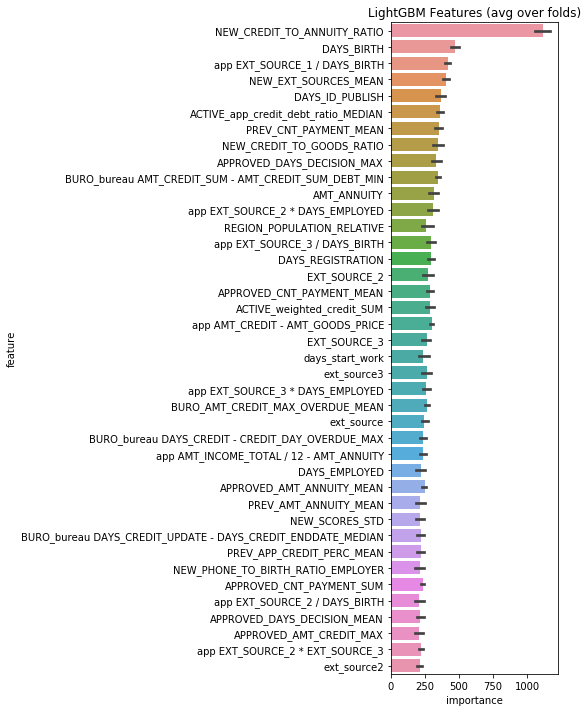

In [9]:
# 前三，第一张表自己的特征，第二章表自己的特征，第三章表原始特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 1030), test shape: (48744, 1030)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.864174	valid_1's auc: 0.795683
Early stopping, best iteration is:
[1641]	training's auc: 0.893307	valid_1's auc: 0.796916
Fold  1 AUC : 0.796916
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.864051	valid_1's auc: 0.792009
Early stopping, best iteration is:
[1784]	training's auc: 0.898326	valid_1's auc: 0.793128
Fold  2 AUC : 0.793132
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.864098	valid_1's auc: 0.791205
Early stopping, best iteration is:
[1394]	training's auc: 0.882779	valid_1's auc: 0.791887
Fold  3 AUC : 0.791889
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.864283	valid_1's auc: 0.792991
Early stopping, best iteration is:
[1371]	training's auc: 0.88234	valid_1's auc: 0.793582
Fold  4 AUC : 0.79

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1504s


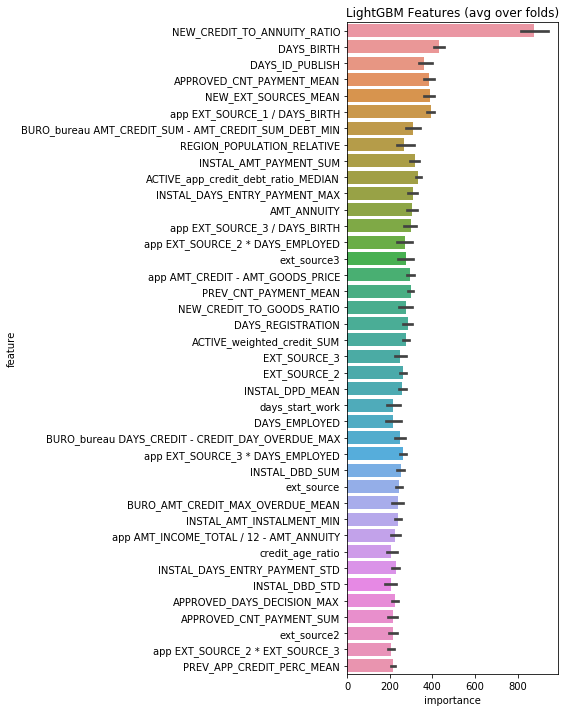

In [26]:
# 所有，第一张表自己的特征，第二章表自己的特征，加入众数，第二张表再次添加特征
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [51]:
def winsor(series, up=99.9, down=0.1):
    unique = np.unique(series.dropna())
    if unique.shape[0] < 30 or unique.shape[0] == len(series):
        return series
    up_val = np.percentile(series.dropna(), up)
    down_val = np.percentile(series.dropna(), down)
    return series.map(lambda x: x if down_val < x < up_val else np.nan)

In [ ]:
# 所有，第一张表原始的特征（加上部分显著特征），第二章表自己的特征，再进行异常值处理，终止，效果不好，重新进行其他表的特征生成
# LB=
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 829), test shape: (48744, 829)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861948	valid_1's auc: 0.794445


array([], dtype=float64)

Starting LightGBM. Train shape: (307507, 829), test shape: (48744, 829)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861614	valid_1's auc: 0.794991
Early stopping, best iteration is:
[1587]	training's auc: 0.887617	valid_1's auc: 0.795612
Fold  1 AUC : 0.795612
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860523	valid_1's auc: 0.790918
Early stopping, best iteration is:
[1539]	training's auc: 0.88506	valid_1's auc: 0.792021
Fold  2 AUC : 0.792021
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861214	valid_1's auc: 0.791294
Early stopping, best iteration is:
[1785]	training's auc: 0.895299	valid_1's auc: 0.792424
Fold  3 AUC : 0.792424
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861051	valid_1's auc: 0.793299
Early stopping, best iteration is:
[1347]	training's auc: 0.877563	valid_1's auc: 0.793948
Fold  4 AUC : 0.7939

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1172s


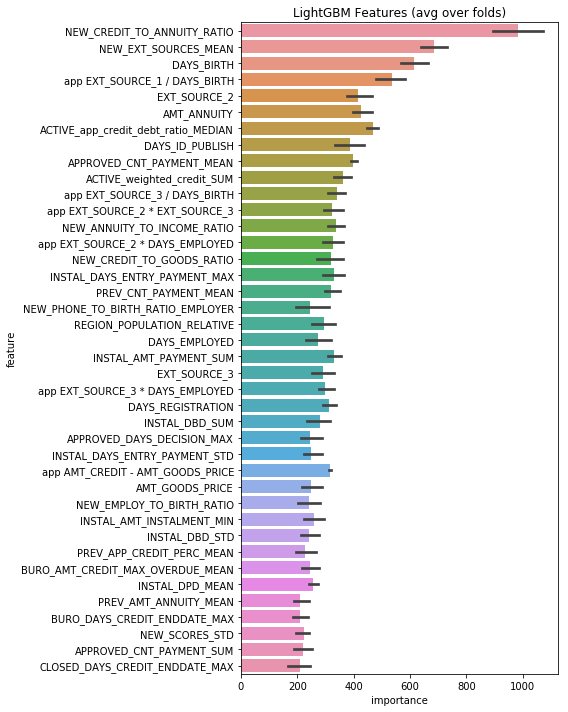

In [7]:
# 所有，第一张表原始的特征（加上部分显著特征），第二章表自己的特征
# LB=0.796
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 823), test shape: (48744, 823)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860716	valid_1's auc: 0.794258
Early stopping, best iteration is:
[1793]	training's auc: 0.894882	valid_1's auc: 0.795497
Fold  1 AUC : 0.795497
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860447	valid_1's auc: 0.790748
[2000]	training's auc: 0.901941	valid_1's auc: 0.792359
Early stopping, best iteration is:
[2103]	training's auc: 0.905452	valid_1's auc: 0.792434
Fold  2 AUC : 0.792435
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860088	valid_1's auc: 0.791627
[2000]	training's auc: 0.90206	valid_1's auc: 0.792416
Early stopping, best iteration is:
[1854]	training's auc: 0.897173	valid_1's auc: 0.792495
Fold  3 AUC : 0.792495
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860394	valid_1's auc: 0.791868

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1354s


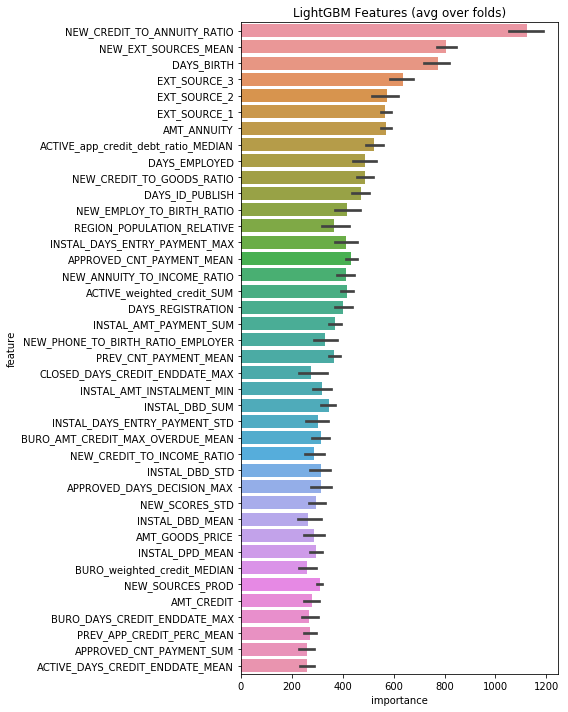

In [146]:
# 所有，第一张表原始的特征，第二章表自己的特征
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 866), test shape: (48744, 866)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86255	valid_1's auc: 0.795424
Early stopping, best iteration is:
[1537]	training's auc: 0.886705	valid_1's auc: 0.796529
Fold  1 AUC : 0.796529
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861922	valid_1's auc: 0.791089
Early stopping, best iteration is:
[1655]	training's auc: 0.890853	valid_1's auc: 0.792307
Fold  2 AUC : 0.792307
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861982	valid_1's auc: 0.791525
[2000]	training's auc: 0.903577	valid_1's auc: 0.792144
Early stopping, best iteration is:
[1809]	training's auc: 0.896843	valid_1's auc: 0.79238
Fold  3 AUC : 0.792380
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.86278	valid_1's auc: 0.792632
Early stopping, best iteration is:
[1480]	training's auc:

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1242s


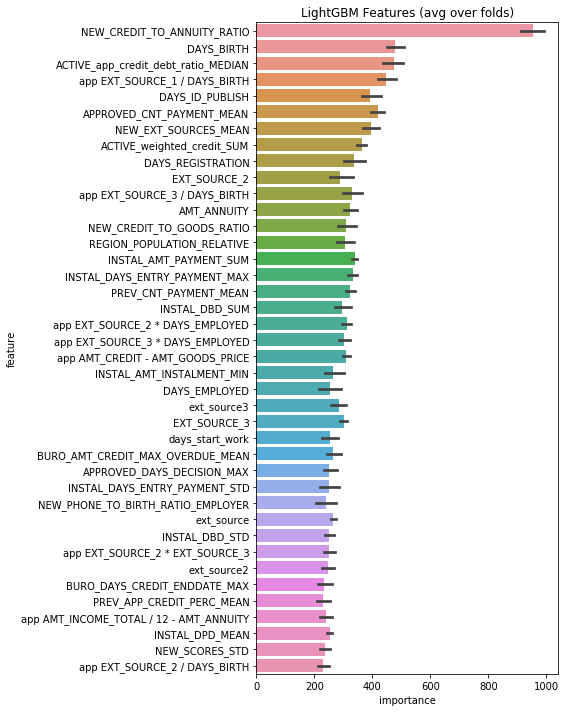

In [142]:
# 所有，第一张表自己的特征，第二章表自己的特征
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [116]:
feat_importance.loc[feat_importance.feature=='HAS_NO_BALANCE_DATA']

,feature,importance,fold
427,HAS_NO_BALANCE_DATA,0,1
427,HAS_NO_BALANCE_DATA,1,2
427,HAS_NO_BALANCE_DATA,1,3
427,HAS_NO_BALANCE_DATA,0,4
427,HAS_NO_BALANCE_DATA,0,5


Starting LightGBM. Train shape: (307507, 380), test shape: (48744, 380)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.840841	valid_1's auc: 0.778354
Early stopping, best iteration is:
[1386]	training's auc: 0.858855	valid_1's auc: 0.778813
Fold  1 AUC : 0.778813
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.839345	valid_1's auc: 0.775993
Early stopping, best iteration is:
[1103]	training's auc: 0.844328	valid_1's auc: 0.776228
Fold  2 AUC : 0.776228
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.841196	valid_1's auc: 0.775156
Early stopping, best iteration is:
[1597]	training's auc: 0.866605	valid_1's auc: 0.776097
Fold  3 AUC : 0.776097
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.840951	valid_1's auc: 0.775341
Early stopping, best iteration is:
[1706]	training's auc: 0.871823	valid_1's auc: 0.77631
Fold  4 AUC : 0.7763

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 454s


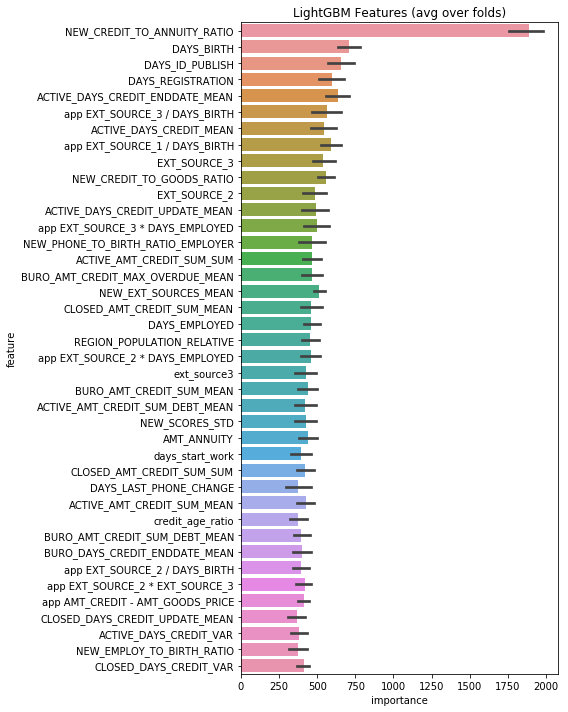

In [48]:
# 前两张表，第一张表自己的特征，第二章表原始
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 800), test shape: (48744, 800)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860465	valid_1's auc: 0.793468
Early stopping, best iteration is:
[1610]	training's auc: 0.888427	valid_1's auc: 0.794358
Fold  1 AUC : 0.794358
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859899	valid_1's auc: 0.78974
Early stopping, best iteration is:
[1726]	training's auc: 0.892179	valid_1's auc: 0.791112
Fold  2 AUC : 0.791112
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860496	valid_1's auc: 0.789705
Early stopping, best iteration is:
[1594]	training's auc: 0.887616	valid_1's auc: 0.791015
Fold  3 AUC : 0.791015
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860655	valid_1's auc: 0.791489
Early stopping, best iteration is:
[1498]	training's auc: 0.884246	valid_1's auc: 0.792509
Fold  4 AUC : 0.7925

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1160s


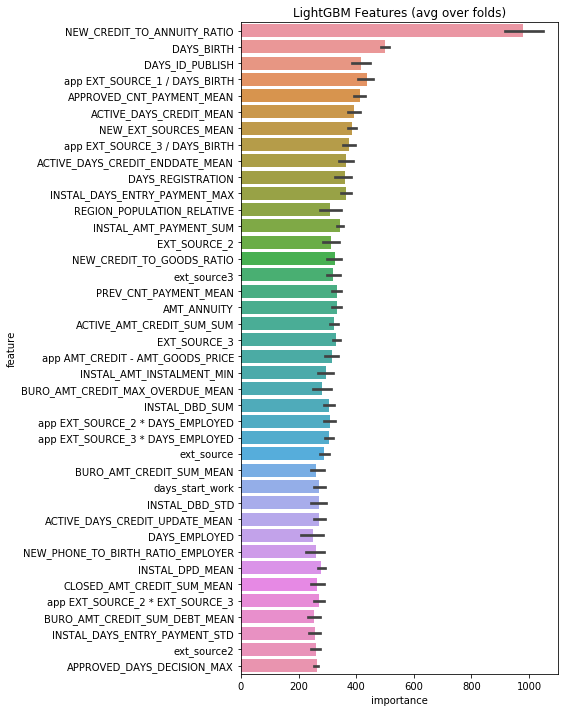

In [20]:
# 所有表，加入https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization/notebook的特征，调整xgb系数以防止过拟合
# LB=0.793 mmp!
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 800), test shape: (48744, 800)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860226	valid_1's auc: 0.793246
Early stopping, best iteration is:
[1568]	training's auc: 0.886659	valid_1's auc: 0.794355
Fold  1 AUC : 0.794355
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860338	valid_1's auc: 0.789314
Early stopping, best iteration is:
[1440]	training's auc: 0.880998	valid_1's auc: 0.790279
Fold  2 AUC : 0.790279
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.860484	valid_1's auc: 0.789715
Early stopping, best iteration is:
[1557]	training's auc: 0.886698	valid_1's auc: 0.79123
Fold  3 AUC : 0.791230
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.861446	valid_1's auc: 0.791465
Early stopping, best iteration is:
[1480]	training's auc: 0.883909	valid_1's auc: 0.792437
Fold  4 AUC : 0.7924

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1886s


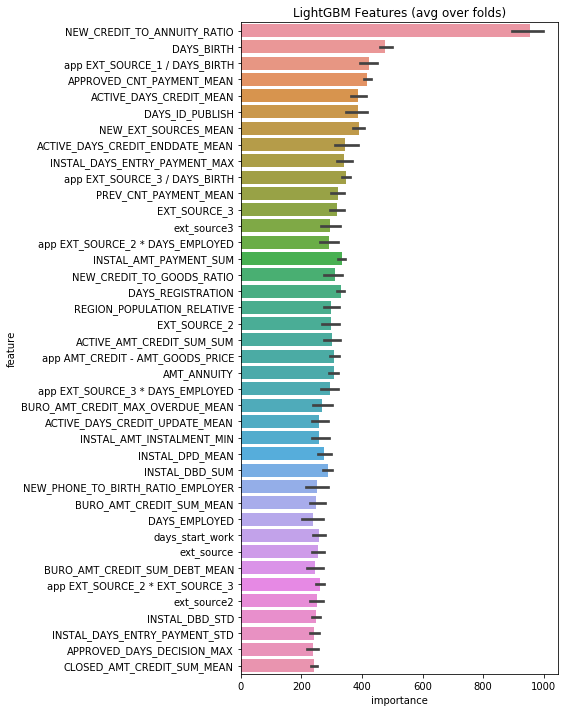

In [18]:
# 所有表，加入https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization/notebook的特征
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 285), test shape: (48744, 285)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.82831	valid_1's auc: 0.771477
Early stopping, best iteration is:
[1015]	training's auc: 0.829003	valid_1's auc: 0.771526
Fold  1 AUC : 0.771526
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.828333	valid_1's auc: 0.768027
Early stopping, best iteration is:
[989]	training's auc: 0.827862	valid_1's auc: 0.76808
Fold  2 AUC : 0.768080
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.829669	valid_1's auc: 0.768757
Early stopping, best iteration is:
[1090]	training's auc: 0.83378	valid_1's auc: 0.768868
Fold  3 AUC : 0.768868
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.82925	valid_1's auc: 0.769854
Early stopping, best iteration is:
[948]	training's auc: 0.826934	valid_1's auc: 0.769895
Fold  4 AUC : 0.769895
Tr

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 383s


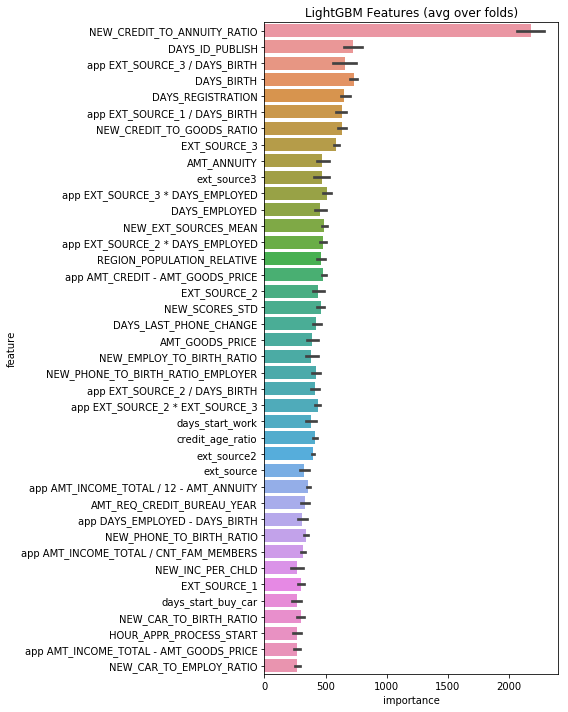

In [16]:
# 只用第一张表，加入https://www.kaggle.com/aantonova/797-lgbm-and-bayesian-optimization/notebook的特征
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 257), test shape: (48744, 257)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.826617	valid_1's auc: 0.772142
Early stopping, best iteration is:
[1024]	training's auc: 0.82766	valid_1's auc: 0.772217
Fold  1 AUC : 0.772217
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.826172	valid_1's auc: 0.767557
Early stopping, best iteration is:
[1244]	training's auc: 0.836418	valid_1's auc: 0.7677
Fold  2 AUC : 0.767700
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.826898	valid_1's auc: 0.769422
Early stopping, best iteration is:
[1104]	training's auc: 0.831456	valid_1's auc: 0.769467
Fold  3 AUC : 0.769467
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.827393	valid_1's auc: 0.769032
Early stopping, best iteration is:
[1239]	training's auc: 0.837695	valid_1's auc: 0.76922
Fold  4 AUC : 0.769220


/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 402s


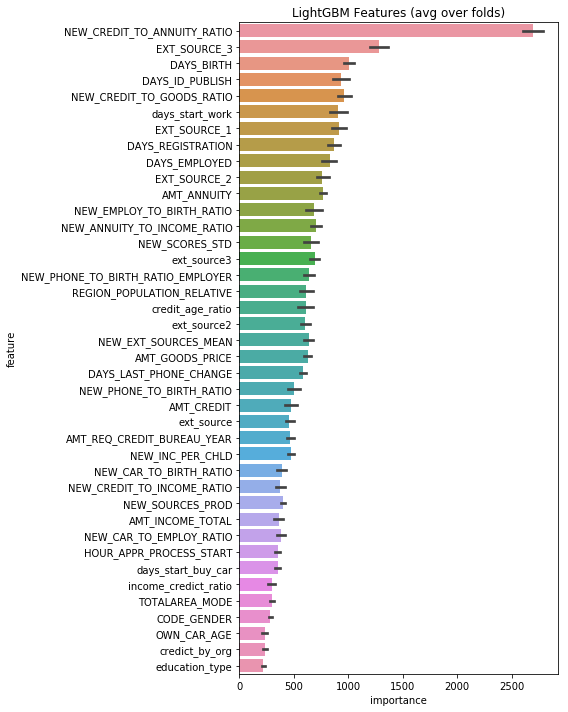

In [150]:
# 只用第一张表，加入我的特征
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 240), test shape: (48744, 240)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.824703	valid_1's auc: 0.771787
Early stopping, best iteration is:
[997]	training's auc: 0.824567	valid_1's auc: 0.771793
Fold  1 AUC : 0.771793
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.824725	valid_1's auc: 0.767916
Early stopping, best iteration is:
[1233]	training's auc: 0.834901	valid_1's auc: 0.768235
Fold  2 AUC : 0.768235
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.8251	valid_1's auc: 0.769383
Early stopping, best iteration is:
[1087]	training's auc: 0.82897	valid_1's auc: 0.76951
Fold  3 AUC : 0.769510
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.825311	valid_1's auc: 0.769009
Early stopping, best iteration is:
[999]	training's auc: 0.82527	valid_1's auc: 0.769023
Fold  4 AUC : 0.769023
Tra

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 364s


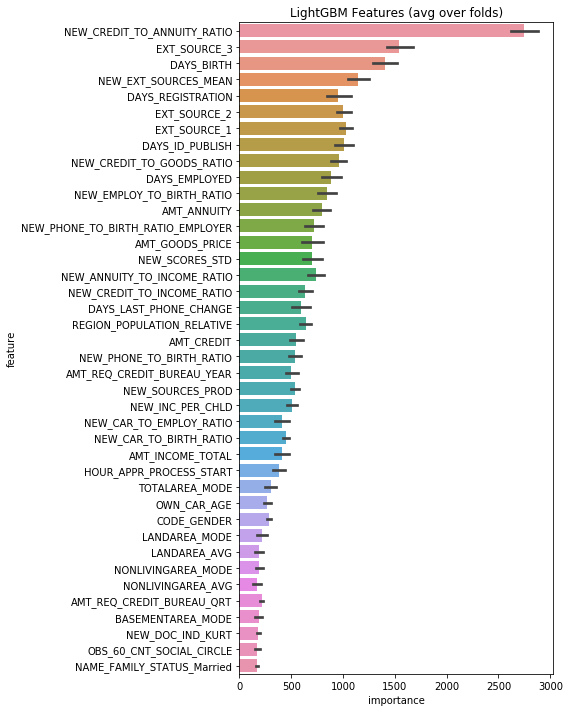

In [5]:
# 只用第一张表，原始结果
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

In [ ]:

submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 751), test shape: (48744, 751)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.85871	valid_1's auc: 0.792458
[2000]	training's auc: 0.900703	valid_1's auc: 0.79385
Early stopping, best iteration is:
[1910]	training's auc: 0.897818	valid_1's auc: 0.794073
Fold  1 AUC : 0.794073
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.85875	valid_1's auc: 0.789392
[2000]	training's auc: 0.900071	valid_1's auc: 0.790751
Early stopping, best iteration is:
[1852]	training's auc: 0.894898	valid_1's auc: 0.790859
Fold  2 AUC : 0.790859
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858597	valid_1's auc: 0.789619
Early stopping, best iteration is:
[1471]	training's auc: 0.880494	valid_1's auc: 0.790434
Fold  3 AUC : 0.790434
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859361	valid_1's auc: 0.790654
E

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 2072s


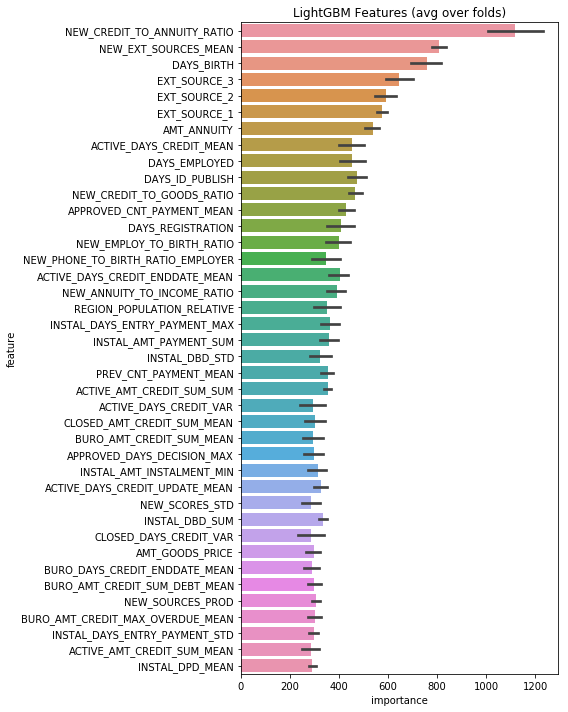

In [7]:
# add 36542 of prev_app
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

Starting LightGBM. Train shape: (307507, 721), test shape: (48744, 721)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.857885	valid_1's auc: 0.792147
Early stopping, best iteration is:
[1593]	training's auc: 0.885066	valid_1's auc: 0.793334
Fold  1 AUC : 0.793334
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858463	valid_1's auc: 0.788323
Early stopping, best iteration is:
[1676]	training's auc: 0.88789	valid_1's auc: 0.7896
Fold  2 AUC : 0.789600
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858565	valid_1's auc: 0.789922
Early stopping, best iteration is:
[1468]	training's auc: 0.880148	valid_1's auc: 0.791146
Fold  3 AUC : 0.791146
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858625	valid_1's auc: 0.790009
Early stopping, best iteration is:
[1347]	training's auc: 0.875416	valid_1's auc: 0.790719
Fold  4 AUC : 0.790719

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1823s


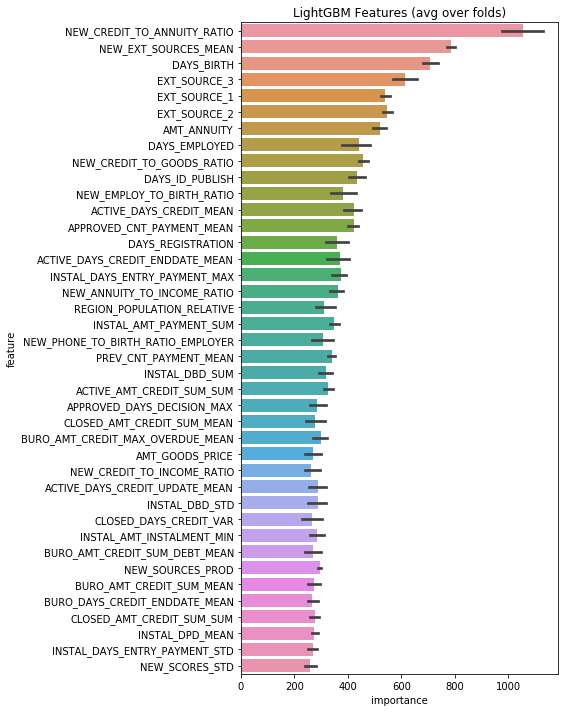

In [6]:
# 原始的
submission_file_name = "submission_kernel02.csv"
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)